In [1]:
from abc import ABC, abstractmethod
from absl import logging
import matplotlib.pyplot as plt
import numpy as np
from typing import Any
from tqdm.notebook import trange
import scipy.stats

In [2]:
class Regression(ABC):
    """Interface for a regression."""

    def __init__(self, x: np.ndarray, y: np.ndarray):
        self.x = np.copy(x)
        self.y = np.copy(y)
        self._perform_regression()

    @property
    def r_squared(self) -> float:
        """Coefficient of determination.

        R squared determines the proportion of variance in the dependent
        variable that can be explained by the variance in the independent
        variable.
        """
        sum_squared_residuals = np.linalg.norm(self.y -
                                               self.evaluate(self.x))**2
        total_sum_squares = np.linalg.norm(self.y - np.mean(self.y))**2
        return 1 - sum_squared_residuals / total_sum_squares

    @abstractmethod
    def evaluate(self, x: float | np.ndarray) -> float | np.ndarray:
        """Evaluates the regression at the given x-values.

        Args:
            x: x-values.

        Returns:
            The y-values corresponding to the x-values.
        """

    @abstractmethod
    def _perform_regression(self) -> None:
        """Performs the regression.

        This function should set the regression coefficients.
        """


class PolynomialRegression(Regression):
    """Performs a polynomial regression."""

    def __init__(self, x: np.ndarray, y: np.ndarray, degree: int):
        self.degree = degree
        self.coeffs = None  # type: np.ndarray
        self.residuals = 0
        super().__init__(x, y)

    @property
    def r_squared(self) -> float:
        """Coefficient of determination."""
        total_sum_squares = np.linalg.norm(self.y - np.mean(self.y))**2
        return 1 - self.residuals / total_sum_squares

    @property
    def coefficients(self) -> float:
        """Coefficients of the polynomial regression.

        The coefficients are sorted in increasing powers.
        """
        return self.coeffs

    def evaluate(self, x: float | np.ndarray) -> float | np.ndarray:
        """Evaluates the polynomial regression at the given x-values.

        Args:
            x: x-values.

        Returns:
            The y-values corresponding to the x-values.
        """
        powers = np.arange(len(self.coeffs))
        powers_of_x = x**powers[:, np.newaxis]
        return np.dot(self.coeffs, powers_of_x)

    def _perform_regression(self) -> None:
        """Performs a polynomial regression.

        This function sets coefficients and residuals, where coefficients are
        the polynomial coefficients.
        """
        powers = np.arange(self.degree + 1)
        A = (self.x**powers[:, np.newaxis]).T
        result, residuals = np.linalg.lstsq(A, self.y, rcond=None)[:2]
        self.coeffs = np.squeeze(result)
        self.residuals = residuals[0] if len(residuals) > 0 else 0


class LinearRegression(PolynomialRegression):
    """Performs a linear regression."""

    def __init__(self, x: np.ndarray, y: np.ndarray):
        super().__init__(x, y, 1)

    @property
    def slope(self) -> float:
        """Slope of the linear regression."""
        return self.coefficients[1]

    @property
    def y_intercept(self) -> float:
        """y-intercept of the linear regression."""
        return self.coefficients[0]


class WeightedLinearRegression(LinearRegression):
    """Performs a linear regression with weighted least squares."""

    def __init__(self, x: np.ndarray, y: np.ndarray, weights: np.ndarray):
        self.weights = np.copy(weights)
        assert np.all(self.weights >= 0)
        super().__init__(x, y)

    @property
    def r_squared(self) -> float:
        """Coefficient of determination."""
        W = np.sqrt(self.weights)
        y_weighted = self.y * W
        total_sum_squares = np.linalg.norm(y_weighted - np.mean(y_weighted))**2
        return 1 - self.residuals / total_sum_squares

    @property
    def x_mean(self):
        """Weighted mean of the x-values."""
        return np.sum(self.weights * self.x) / np.sum(self.weights)

    @property
    def y_mean(self):
        """Weighted mean of the y-values."""
        return np.sum(self.weights * self.y) / np.sum(self.weights)

    @property
    def slope_variance(self) -> float:
        """Variance of the slope of the linear regression.

        This function assumes that the weights are equal to 1/sample variance.
        """
        return 1 / np.sum(self.weights * (self.x - self.x_mean)**2)

    @property
    def y_intercept_variance(self) -> float:
        """Variance of the y-intercept of the linear regression.

        This function assumes that the weights are equal to 1/sample variance.
        """
        return 1 / np.sum(self.weights) + self.slope_variance * self.x_mean**2

    def _perform_regression(self) -> None:
        """Performs a linear regression with weighted least squares.

        This function sets m, b, and residuals, where m is the slope and b is
        the y-intercept.
        """
        A = (self.x**np.arange(2)[:, np.newaxis]).T
        W = np.sqrt(self.weights)
        A_weighted = A * W[:, np.newaxis]
        y_weighted = self.y * W
        result, residuals = np.linalg.lstsq(A_weighted, y_weighted,
                                            rcond=None)[:2]
        self.coeffs = np.squeeze(result)
        self.residuals = residuals[0] if len(residuals) > 0 else 0


class ExponentialRegression(Regression):
    """Performs an exponential regression."""

    def __init__(self, x: np.ndarray, y: np.ndarray):
        self.a = 0
        self.tau = 0
        self.b = 0
        super().__init__(x, y)

    @property
    def time_constant(self) -> float:
        """Returns the time constant."""
        return self.tau

    @property
    def offset(self) -> float:
        """Returns the offset."""
        return self.b

    def evaluate(self, x: float | np.ndarray) -> float | np.ndarray:
        """Evaluates the exponential regression at the given x-values.

        Args:
            x: x-values.

        Returns:
            The y-values corresponding to the x-values.
        """
        return self.a * np.exp(-1 / self.tau * x) + self.b

    def _perform_regression(self) -> None:
        """Performs an exponential regression.

        This function sets a, tau, and b, where y = a * exp(-x/tau) + b are the
        coefficients of the exponential.
        """
        A = np.vstack([self.x, np.ones(len(self.x))]).T
        result = np.squeeze(np.linalg.lstsq(A, np.log(self.y), rcond=None)[0])
        tau_guess, a_guess, b_guess = -1 / result[0], np.exp(result[1]), 0

        # Use an optimizer to find the optimal parameters of the exponential.
        # TODO(titan): Debug why this does not quite work for increasing
        # exponentials.
        def cost(params: np.ndarray):
            """Calculates how well the exponential fits the given data.

            Args:
                params: Three-dimensional vector consisting of (a, tau, b).

            Returns:
                The squared cost between the given exponential and the given
                data.
            """
            a, tau, b = params
            return np.linalg.norm(a * np.exp(-1 / tau * self.x) + b - self.y)

        optimization_results = scipy.optimize.minimize(
            cost,
            np.array([a_guess, tau_guess, b_guess]),
            method="Nelder-Mead",
            options={"maxiter": 10000},
        )
        if not optimization_results.success:
            logging.warning("Optimization failed with message: %s",
                            optimization_results.message)
        self.a, self.tau, self.b = optimization_results.x

In [3]:
# Number of bits in an ADC sample.
NUM_ADC_SAMPLE_BITS = 10

# Maximum difference in LSBs between consecutive ADC samples.
MAX_DIFF_BETWEEN_CONSECUTIVE_ADC_SAMPLES = 100  # LSBs

# Number of ADC samples to average at the end to find the minimum ADC output.
NUM_AVERAGES_FOR_MIN_ADC_OUTPUT = 100

# Empirically determined scaling factor of the exponential measured by SCuM.
EXPONENTIAL_SCALING_FACTOR = 870

# Standard deviation of SCuM's ADC.
SIGMA = 5


class ExponentialAdcData:
    """Represents the ADC samples of a decaying exponential.

    The ADC data is assumed to be a decaying exponential and has decayed
    completely by the end of the samples.
    """

    def __init__(self, samples: np.ndarray, sampling_rate: float):
        assert samples.ndim == 1, "ADC data must be one-dimensional."
        self.samples = np.copy(samples)
        self.sampling_rate = sampling_rate

    @property
    def num_samples(self) -> int:
        """Number of samples."""
        return len(self.samples)

    @property
    def t_axis(self) -> np.ndarray:
        """Time axis in seconds."""
        return np.arange(self.num_samples) / self.sampling_rate

    @property
    def min_adc_output(self) -> float:
        """Minimum ADC output."""
        # Average the last ADC samples to find the minimum ADC output.
        return np.mean(self.samples[-NUM_AVERAGES_FOR_MIN_ADC_OUTPUT:])

    @property
    def max_adc_output(self) -> float:
        """Maximum ADC output."""
        return np.max(self.samples)

    def disambiguate_msb_9(self) -> None:
        """Disambiguates the 9th bit from the ADC data.

        This function fixes any discontinuities in the ADC data caused by the
        stuck MSB.
        """
        # Correct the ADC samples by the value of the MSB.
        correction = 2**(NUM_ADC_SAMPLE_BITS - 1)

        # Fix any discontinuities caused by the MSB bit.
        diffs = np.squeeze(
            np.argwhere(
                np.abs(np.diff(self.samples)) >
                MAX_DIFF_BETWEEN_CONSECUTIVE_ADC_SAMPLES))
        self.samples[:np.min(diffs)] += correction

        # Debounce the ADC data at the discontinuities.
        for i in range(np.min(diffs), np.max(diffs) + 1):
            if self.samples[i] - self.samples[
                    i - 1] < -MAX_DIFF_BETWEEN_CONSECUTIVE_ADC_SAMPLES:
                self.samples[i] += correction

    def filter_samples(self, cutoff_frequency: float = 7) -> None:
        """Filters the noise from the ADC data.

        Args:
            cutoff_frequency: Cutoff frequency in Hz.
        """
        # Use a Butterworth filter.
        butter = scipy.signal.butter(3,
                                     cutoff_frequency,
                                     fs=self.sampling_rate,
                                     output="sos")
        self.samples = scipy.signal.sosfiltfilt(butter, data)

    def perform_exponential_regression(self) -> ExponentialRegression:
        """Performs an exponential regression on the ADC data.

        Returns:
            The exponential regression.
        """
        t = self.t_axis
        three_tau_index = self._estimate_three_tau_index()
        return ExponentialRegression(t[:three_tau_index],
                                     self.samples[:three_tau_index])

    def get_linear_regression_samples(self) -> np.ndarray:
        """Gets the pre-processed ADC samples for linear regressions.

        Any vertical offset is removed, and the natural logarithm is applied.

        Returns:
            The pre-processed ADC samples.
        """
        return np.log(self.samples - self.min_adc_output)

    def perform_linear_regression(self) -> LinearRegression:
        """Performs a linear regression on the ADC data in log space.

        Returns:
            The linear regression in log space.
        """
        t = self.t_axis
        three_tau_index = self._estimate_three_tau_index()
        return LinearRegression(
            t[:three_tau_index],
            self.get_linear_regression_samples()[:three_tau_index])

    def perform_weighted_linear_regression(self) -> WeightedLinearRegression:
        """Performs a weighted linear regression on the ADC data in log space.

        The variance of the ADC samples increases exponentially, and the weights
        are the reciprocals of the corresponding variances.

        Returns:
            The weighted linear regression in log space.
        """
        t = self.t_axis
        three_tau_index = self._estimate_three_tau_index()
        exponential_scaling_factor = self.samples[0] - self.min_adc_output
        variances = (SIGMA / exponential_scaling_factor *
                     np.exp(t / self.estimate_tau()))**2
        weights = 1 / variances
        return WeightedLinearRegression(
            t[:three_tau_index],
            self.get_linear_regression_samples()[:three_tau_index],
            weights[:three_tau_index])

    def perform_polynomial_regression(self,
                                      degree: int = 5) -> PolynomialRegression:
        """Performs a polynomial regression on the ADC data.

        Args:
            degree: Polynomial degree.

        Returns:
            The polynomial regression.
        """
        t = self.t_axis
        three_tau_index = self._estimate_three_tau_index()
        return PolynomialRegression(
            t[:three_tau_index],
            self.samples[:three_tau_index] - self.min_adc_output, degree)

    def estimate_tau(self) -> float:
        """Estimates the time constant based on the three tau index.

        Returns:
            The estimated time constant.
        """
        three_tau_index = self._estimate_three_tau_index()
        return three_tau_index / 3 / self.sampling_rate

    def _estimate_three_tau_index(self) -> int:
        """Estimates the index at 3tau.

        The sample at 3tau corresponds to where the exponential has decayed by 95%.
        Note that this function only estimates 3tau due to the presence of noise.

        Returns:
            The index at 3tau.
        """
        # Average the last ADC samples to find the minimum ADC output.
        three_tau_index = np.argmax(self.samples < 0.95 * self.min_adc_output +
                                    0.05 * self.max_adc_output)
        return three_tau_index

In [4]:
# Offset of the decaying exponential.
EXPONENTIAL_OFFSET = 127

def _generate_transient_adc_data(tau: float,
                                 sampling_rate: float,
                                 num_taus: float = 7,
                                 noise: bool = True) -> np.ndarray:
    """Generates an exponentially decaying ADC data with the given time constant.

    Args:
        tau: Time constant in seconds.
        sampling_rate: Sampling rate in Hz.
        num_taus: Duration of the generated ADC data in number of taus.

    Returns:
        The ADC samples of a decaying exponential.
    """
    # Generate the time axis.
    t_axis = np.arange(0, num_taus * tau, 1 / sampling_rate)

    # Generate a decaying exponential with an offset.
    exponential = EXPONENTIAL_SCALING_FACTOR * np.exp(
        -t_axis / tau) + EXPONENTIAL_OFFSET

    if noise:
        # Generate some noise.
        # Round the ADC samples to the nearest integer.
        return np.round(exponential + np.random.normal(scale=SIGMA, size=exponential.shape))
    return exponential

Initial experiment to test the expected and measured slope variance with $\tau = 2$.  Looks like even the slope variances are not matching.  Let's go more upstream.

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/04/bm27wk9s3fz7qppjtq4lk6yr0000gp/T/ipykernel_92986/2890560139.py:104: RuntimeWarning: invalid value encountered in log
  return np.log(self.samples - self.min_adc_output)
/var/folders/04/bm27wk9s3fz7qppjtq4lk6yr0000gp/T/ipykernel_92986/2890560139.py:104: RuntimeWarning: divide by zero encountered in log
  return np.log(self.samples - self.min_adc_output)


slope mean=0.5017795307775123, stddev=0.0009914154810304811
slope expected stddev=0.0006605504302090086
time constant mean=1.992914900430882, stddev=0.003937434101147466


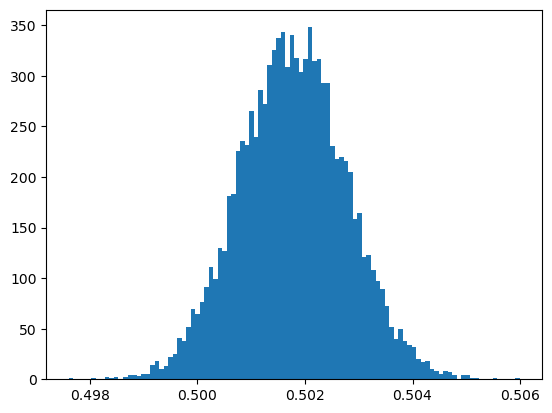

In [5]:
tau = 2
fs = 100
slopes = []
expected_slope_variances = []
time_constants = []

np.random.seed(3)
for _ in trange(10000):
    # Generate the data.
    y = _generate_transient_adc_data(tau, fs)
    adc_data = ExponentialAdcData(y, fs)
    
    # Weighted least squares.
    weighted_linear_regression = adc_data.perform_weighted_linear_regression()
    slopes.append(-weighted_linear_regression.slope)
    expected_slope_variances.append(np.sqrt(weighted_linear_regression.slope_variance))
    time_constants.append(-1 / weighted_linear_regression.slope)

slope_mean = np.mean(slopes)
slope_stddev = np.std(slopes)
print(f"slope mean={slope_mean}, stddev={slope_stddev}")
print(f"slope expected stddev={np.mean(expected_slope_variances)}")
print(f"time constant mean={np.mean(time_constants)}, stddev={np.std(time_constants)}")
plt.hist(slopes, bins=100)
plt.show()

Let's verify the variance of each sample.

In [6]:
num_adc_data = 50000
multiple_adc_data = np.zeros((num_adc_data, 7 * fs * tau))
multiple_log_adc_data = np.zeros((num_adc_data, 7 * fs * tau))
for i in range(num_adc_data):
    multiple_adc_data[i] = _generate_transient_adc_data(tau, fs)
    exponential_adc_data = ExponentialAdcData(multiple_adc_data[i], fs)
    multiple_log_adc_data[i] = exponential_adc_data.get_linear_regression_samples()

/var/folders/04/bm27wk9s3fz7qppjtq4lk6yr0000gp/T/ipykernel_92986/2890560139.py:104: RuntimeWarning: invalid value encountered in log
  return np.log(self.samples - self.min_adc_output)
/var/folders/04/bm27wk9s3fz7qppjtq4lk6yr0000gp/T/ipykernel_92986/2890560139.py:104: RuntimeWarning: divide by zero encountered in log
  return np.log(self.samples - self.min_adc_output)


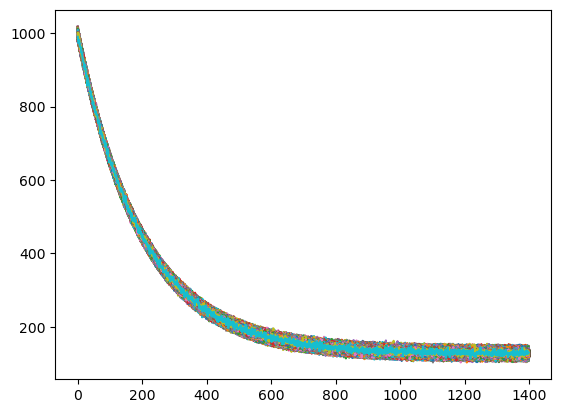

In [7]:
# Plot the generated data
for i in range(len(multiple_adc_data)):
    plt.plot(multiple_adc_data[i])
plt.show()

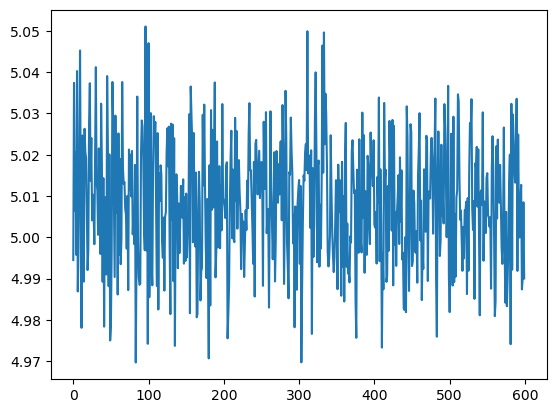

5.008234565771627

In [8]:
three_tau_index = int(3 * fs * tau)

# Plot the stddev of linear samples.
sample_stddevs = np.std(multiple_adc_data, axis=0)
plt.plot(sample_stddevs[:three_tau_index])
plt.show()
np.mean(sample_stddevs[:three_tau_index])

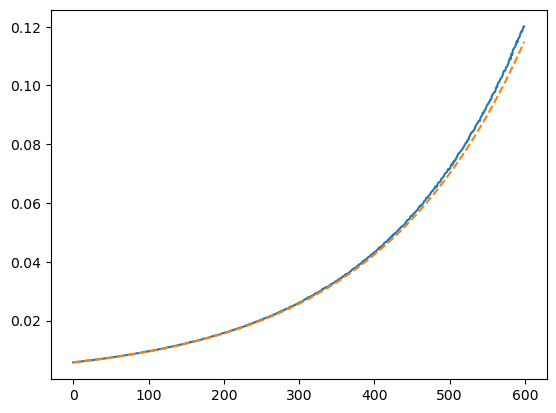

In [9]:
three_tau_index = int(3 * fs * tau)

# Plot the stddev of log samples.
sample_log_stddevs = np.std(multiple_log_adc_data, axis=0)
expected_log_stddevs = SIGMA / EXPONENTIAL_SCALING_FACTOR * np.exp(np.arange(7 * fs * tau) / (fs * tau))
plt.plot(sample_log_stddevs[:three_tau_index])
plt.plot(expected_log_stddevs[:three_tau_index], "--")
plt.show()

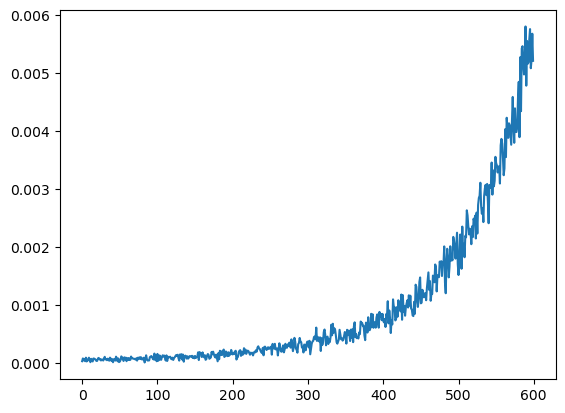

In [10]:
# Plot the difference
plt.plot(sample_log_stddevs[:three_tau_index] - expected_log_stddevs[:three_tau_index])
plt.show()

Now let's try with the noise added after the log operation.

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/04/bm27wk9s3fz7qppjtq4lk6yr0000gp/T/ipykernel_92986/2890560139.py:104: RuntimeWarning: invalid value encountered in log
  return np.log(self.samples - self.min_adc_output)


slope mean=0.5017469464494064, stddev=0.0006044184827400696
slope expected stddev=0.0006016024226290427


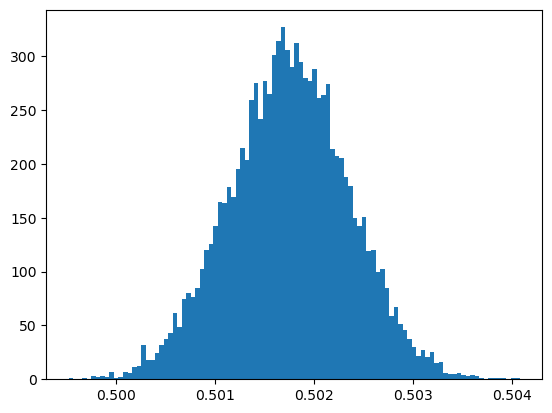

In [11]:
tau = 2
fs = 100
slopes = []
expected_slope_variances = []
three_tau_index = int(3 * fs * tau)

np.random.seed(5)
for _ in trange(10000):
    # Generate the data.
    y = _generate_transient_adc_data(tau, fs, noise=False)
    adc_data = ExponentialAdcData(y, fs)
    
    # Expected sample stddev.
    expected_sample_stddev = SIGMA / EXPONENTIAL_SCALING_FACTOR * np.exp(np.arange(7 * fs * tau) / (fs * tau))
    weighted_linear_regression_input = adc_data.get_linear_regression_samples() + np.random.normal(scale=expected_sample_stddev, size=adc_data.samples.shape)
    
    # Weighted least squares.
    weights = 1 / expected_sample_stddev**2
    weighted_linear_regression = WeightedLinearRegression(
        adc_data.t_axis[:three_tau_index],
        weighted_linear_regression_input[:three_tau_index],
        weights[:three_tau_index])
    slopes.append(-weighted_linear_regression.slope)
    expected_slope_variances.append(np.sqrt(weighted_linear_regression.slope_variance))

slope_mean = np.mean(slopes)
slope_stddev = np.std(slopes)
print(f"slope mean={slope_mean}, stddev={slope_stddev}")
print(f"slope expected stddev={np.mean(expected_slope_variances)}")
plt.hist(slopes, bins=100)
plt.show()

Now let's check the PDFs.

In [12]:
xstep = 0.0001
x = np.arange(-10, 10, xstep)

In [13]:
fs = 100
tau = 2
k = int(3 * fs * tau)
sigma_prime = SIGMA / EXPONENTIAL_SCALING_FACTOR * np.exp(k / (fs * tau))

# Full PDF
f_full = 1 / (np.sqrt(2 * np.pi) * SIGMA) * np.exp(-(EXPONENTIAL_SCALING_FACTOR**2 * np.exp(-2 * k / (fs * tau)) * (np.exp(x) - 1)**2) / (2 * SIGMA**2)) * EXPONENTIAL_SCALING_FACTOR * np.exp(x - k / (fs * tau))

# Approximated once
f_approx_1 = 1 / (np.sqrt(2 * np.pi) * sigma_prime) * np.exp(-x**2 / (2 * sigma_prime**2)) * (1 + x)

# Approximated to Gaussian
f_approx_2 = 1 / (np.sqrt(2 * np.pi) * sigma_prime) * np.exp(-x**2 / (2 * sigma_prime**2))

In [14]:
sum_f_full = np.sum(xstep * f_full)
sum_f_approx_1 = np.sum(xstep * f_approx_1)
sum_f_approx_2 = np.sum(xstep * f_approx_2)
print("Sum f full:", sum_f_full)
print("Sum f approx 1:", sum_f_approx_1)
print("Sum f approx 2:", sum_f_approx_2)

Sum f full: 1.0000000000023308
Sum f approx 1: 1.0000000000023306
Sum f approx 2: 1.0000000000023308


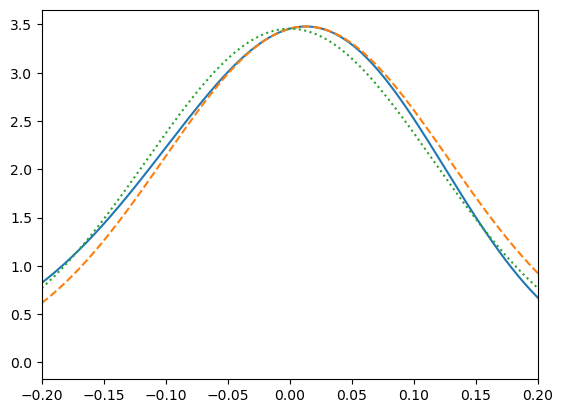

In [15]:
# Plot the PDF
plt.plot(x, f_full)
plt.plot(x, f_approx_1, "--")
plt.plot(x, f_approx_2, ":")
plt.xlim([-0.2, 0.2])
plt.show()

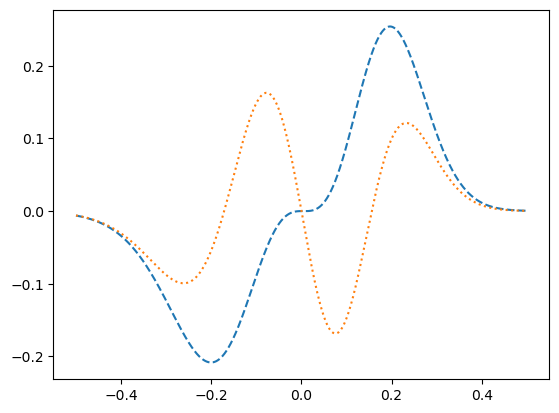

In [16]:
# Plot the difference in the PDF
select = np.abs(x) < 0.5
plt.plot(x[select], f_approx_1[select] - f_full[select], "--")
plt.plot(x[select], f_approx_2[select] - f_full[select], ":")
plt.show()

In [17]:
# Calculate the variance of the PDF and its approximations
mean_f_full = np.sum(x * f_full * xstep)
mean_f_approx_1 = np.sum(x * f_approx_1 * xstep)
mean_f_approx_2 = np.sum(x * f_approx_2 * xstep)
print("Mean f full:", mean_f_full)
print("Mean f approx 1:", mean_f_approx_1)
print("Mean f approx 2:", mean_f_approx_2)

mean_f_full_squared = np.sum(x**2 * f_full * xstep)
mean_f_approx_1_squared = np.sum(x**2 * f_approx_1 * xstep)
mean_f_approx_2_squared = np.sum(x**2 * f_approx_2 * xstep)

var_f_full = mean_f_full_squared - mean_f_full**2
var_f_approx_1 = mean_f_approx_1_squared - mean_f_approx_1**2
var_f_approx_2 = mean_f_approx_2_squared - mean_f_approx_2**2
print("Var f full:", var_f_full)
print("Var f approx 1:", var_f_approx_1)
print("Var f approx 2:", var_f_approx_2)

Mean f full: -0.0068020595790845
Mean f approx 1: 0.013325036117508106
Mean f approx 2: -8.362306301988478e-18
Var f full: 0.013796465263244127
Var f approx 1: 0.013147479529975208
Var f approx 2: 0.013325036117508102


In [18]:
# Match up the unapproximated variance with the simulated variance
three_tau_index = int(3 * fs * tau)

# Plot the stddev of log samples.
sample_log_stddevs = np.std(multiple_log_adc_data, axis=0)
expected_log_stddevs = []
expected_log_stddevs_approx1 = []
expected_log_stddevs_approx2 = []
xstep = 0.0001
x = np.arange(-10, 10, xstep)
for k in np.arange(5 * fs * tau):
    f_full = 1 / (np.sqrt(2 * np.pi) * SIGMA) * np.exp(-(EXPONENTIAL_SCALING_FACTOR**2 * np.exp(-2 * k / (fs * tau)) * (np.exp(x) - 1)**2) / (2 * SIGMA**2)) * EXPONENTIAL_SCALING_FACTOR * np.exp(x - (k / (fs * tau)))
    mean_f_full = np.sum(x * f_full * xstep)
    mean_f_full_squared = np.sum(x**2 * f_full * xstep)
    var_f_full = mean_f_full_squared - mean_f_full**2
    expected_log_stddevs.append(np.sqrt(var_f_full))
    
    # Calculate approximations.
    sigma_prime = SIGMA / EXPONENTIAL_SCALING_FACTOR * np.exp(k / (fs * tau))
    f_approx_1 = 1 / (np.sqrt(2 * np.pi) * sigma_prime) * np.exp(-x**2 / (2 * sigma_prime**2)) * (1 + x)
    mean_f_approx_1 = np.sum(x * f_approx_1 * xstep)
    mean_f_approx_1_squared = np.sum(x**2 * f_approx_1 * xstep)
    var_f_approx_1 = mean_f_approx_1_squared - mean_f_approx_1**2
    expected_log_stddevs_approx1.append(np.sqrt(var_f_approx_1))

    f_approx_2 = 1 / (np.sqrt(2 * np.pi) * sigma_prime) * np.exp(-x**2 / (2 * sigma_prime**2))
    mean_f_approx_2 = np.sum(x * f_approx_2 * xstep)
    mean_f_approx_2_squared = np.sum(x**2 * f_approx_2 * xstep)
    var_f_approx_2 = mean_f_approx_2_squared - mean_f_approx_2**2
    expected_log_stddevs_approx2.append(np.sqrt(var_f_approx_2))

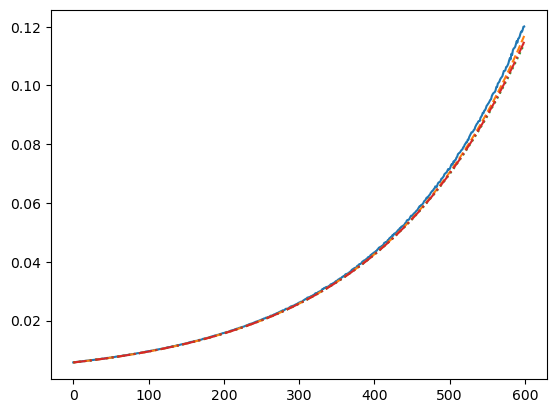

In [19]:
plt.plot(sample_log_stddevs[:three_tau_index])
plt.plot(expected_log_stddevs[:three_tau_index], "--")
plt.plot(expected_log_stddevs_approx1[:three_tau_index], ":")
plt.plot(expected_log_stddevs_approx2[:three_tau_index], "-.")
plt.show()

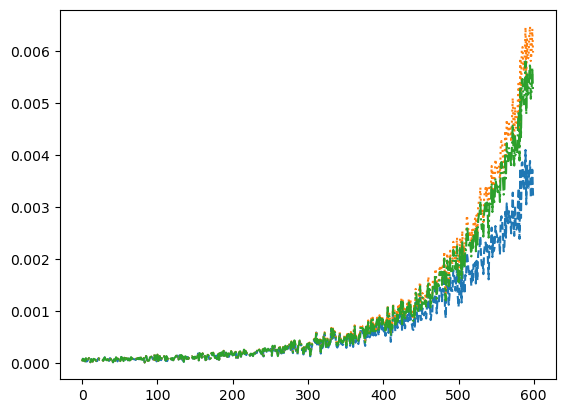

In [20]:
plt.plot(sample_log_stddevs[:three_tau_index] - expected_log_stddevs[:three_tau_index], "--")
plt.plot(sample_log_stddevs[:three_tau_index] - expected_log_stddevs_approx1[:three_tau_index], ":")
plt.plot(sample_log_stddevs[:three_tau_index] - expected_log_stddevs_approx2[:three_tau_index], "-.")
plt.show()